<a href="https://colab.research.google.com/github/hkoenicke/UCDPA_HeikeKoenicke/blob/main/WeatherData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Import packages

import requests
from bs4 import BeautifulSoup
import re
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import fnmatch
import os.path
import datetime

# Data Analysis
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path_dwd = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/'
url_weather_stations = path_dwd + 'historical/KL_Tageswerte_Beschreibung_Stationen.txt'



In [4]:
# read information about weather stations from the website into a pandas data frame
df_weather_stations = pd.DataFrame()
df_weather_stations = pd.read_fwf(url_weather_stations,
                               encoding='ISO-8859-1',
                               header=None,
                               skiprows=[0, 1],
                               names=['Station ID', 'First Date', 'Last Date',
                                   'Altitude', 'Latitude', 'Longitude',
                                   'Station Name', 'Federal State'])

# convert 'First Date' and 'Last Date' from int to datetime format
df_weather_stations[['First Date','Last Date']] = df_weather_stations[['First Date','Last Date']].apply(pd.to_datetime,format='%Y%m%d')

df_weather_stations.head()

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State
0,1,1937-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
1,3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
2,11,1980-09-01,2020-09-30,680,47.9736,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg
3,44,1969-01-01,2023-08-16,44,52.9336,8.2370,Großenkneten,Niedersachsen
4,52,1969-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein


In [23]:
df_weather_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Station ID     1351 non-null   int64         
 1   First Date     1351 non-null   datetime64[ns]
 2   Last Date      1351 non-null   datetime64[ns]
 3   Altitude       1351 non-null   int64         
 4   Latitude       1351 non-null   float64       
 5   Longitude      1351 non-null   float64       
 6   Station Name   1351 non-null   object        
 7   Federal State  1351 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 84.6+ KB


In [5]:
# Get list of all zip files for historic data

page_info = requests.get(path_dwd +'historical').text

# read file names using regular expression
files = re.findall(r"(?<=href=\")tageswerte_KL_[0-9]+_[0-9]+_\w*\.zip",page_info)

# get station ids using regular expression
station_ids = re.findall(r"(?<=href=\"tageswerte_KL_)[0-9]+",page_info)
# convert to int
station_ids = [int(x) for x in station_ids]

# convert the two lists into a dictionary
station_file_names = {}
station_file_names = {station_ids[i]: files[i] for i in range(len(station_ids))}

print(station_file_names)

{1: 'tageswerte_KL_00001_19370101_19860630_hist.zip', 3: 'tageswerte_KL_00003_18910101_20110331_hist.zip', 11: 'tageswerte_KL_00011_19800901_20200930_hist.zip', 44: 'tageswerte_KL_00044_19690101_20221231_hist.zip', 52: 'tageswerte_KL_00052_19690101_20011231_hist.zip', 61: 'tageswerte_KL_00061_19750701_19780831_hist.zip', 70: 'tageswerte_KL_00070_19730601_19860930_hist.zip', 71: 'tageswerte_KL_00071_19861101_20191231_hist.zip', 72: 'tageswerte_KL_00072_19780901_19950531_hist.zip', 73: 'tageswerte_KL_00073_19590301_20221231_hist.zip', 78: 'tageswerte_KL_00078_19610101_20221231_hist.zip', 90: 'tageswerte_KL_00090_19880219_20221231_hist.zip', 91: 'tageswerte_KL_00091_19781101_20221231_hist.zip', 93: 'tageswerte_KL_00093_19771201_19781031_hist.zip', 96: 'tageswerte_KL_00096_20190409_20221231_hist.zip', 98: 'tageswerte_KL_00098_18870215_19541231_hist.zip', 102: 'tageswerte_KL_00102_19980101_20221231_hist.zip', 116: 'tageswerte_KL_00116_18990601_19730531_hist.zip', 125: 'tageswerte_KL_00125_1

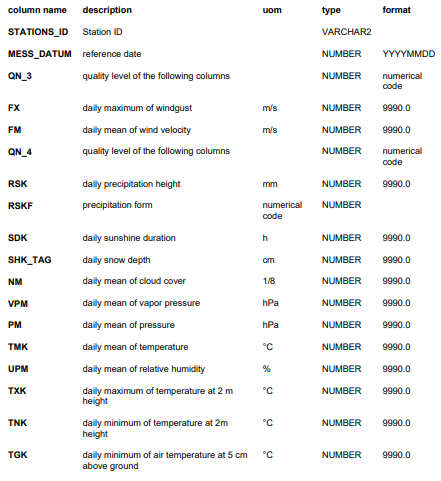

In [5]:
# Process zip files

# create data list for climate data
weather_list =  []
for id in station_ids:
  for category in ['historical','recent']:
    if category == 'historical':
      url = path_dwd + 'historical/' + station_file_names[id]
    else:
      url = path_dwd + 'recent/tageswerte_KL_' + str(id).zfill(5) + '_akt.zip'

    try:
      # open zip file
      zf = ZipFile(BytesIO(urlopen(url).read()))

      # find csv file starting with 'produkt'
      csv_file_name = fnmatch.filter(zf.namelist(),'produkt*.txt')

      # open zipped csv file
      file_csv = zf.open(*csv_file_name)

      # read specific columns and append it to the weather list
      weather_list.append(pd.read_csv(file_csv,sep=';',usecols=['STATIONS_ID',
                                                                'MESS_DATUM',
                                                                '  FX',# daily max. windgust
                                                                '  FM',# daily mean wind velocity
                                                                ' RSK',# daily precipitation height
                                                                'RSKF',# precipitation form
                                                                ' SDK',# daily sunshine duration
                                                                'SHK_TAG',# daily snow depth
                                                                '  NM',# daily mean cloud cover
                                                                ' VPM',# daily mean vapor pressure
                                                                '  PM',# daily mean pressure
                                                                ' TMK',# daily mean temperature
                                                                ' UPM',# daily mean of relative humidity
                                                                ' TXK',# daily max. temperature at 2m height
                                                                ' TNK',# daily min. temperature at 2m height
                                                                ' TGK',# daily min. air temperature at 5cm above ground
                                                                'QN_3',# quality level FX & FM
                                                                'QN_4'],# quality level rest
                                      parse_dates=['MESS_DATUM']))

      # close txt.file and zip file
      file_csv.close()
      zf.close()

    except IOError: # ignore
      pass

# create pandas data frame with weather list
weather = pd.concat(weather_list)
# rename columns
weather = weather.rename(columns={'STATIONS_ID': 'Station ID',
                                  'MESS_DATUM': 'Date',
                                  '  FX': 'WindGustMax',
                                  '  FM': 'WindSpeed',
                                  ' RSK': 'Precipitation',
                                  'RSKF': 'PrecipitationForm',
                                  ' SDK': 'SunshineDuration',
                                  'SHK_TAG': 'SnowDepth',
                                  '  NM': 'Clouds',
                                  ' VPM': 'VaporPressure',
                                  '  PM': 'Pressure',
                                  ' TMK': 'Temperature',
                                  ' UPM': 'Humidity',
                                  ' TXK': 'TempMax',
                                  ' TNK': 'TempMin',
                                  ' TGK': 'TempMinGround',})
# replace missing values
weather = (weather.replace(-999.0,np.nan))

In [6]:
weather.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 17910093 entries, 0 to 7364
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Station             int64         
 1   Date                datetime64[ns]
 2   QN_3                float64       
 3   Wind_gust_max       float64       
 4   Wind_speed          float64       
 5   QN_4                float64       
 6   Precipitation       float64       
 7   Precipitation_form  float64       
 8   Sunshine            float64       
 9   Snow                float64       
 10  Clouds              float64       
 11  Temperature         float64       
 12  Humidity            float64       
 13  Max_temp            float64       
 14  Min_temp            float64       
 15  Min_temp_ground     float64       
dtypes: datetime64[ns](1), float64(14), int64(1)
memory usage: 2.3 GB


In [7]:
# save in csv file to Google Drive
weather.to_csv('/content/drive/MyDrive/climate_data.csv.gz', index=False, compression='gzip')

# download to local drive
from google.colab import files
files.download("climate_data.csv.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
weather.info()
weather.describe()

ERROR:root:Did not find quickchart key chart-55bd5f30-ff1d-42a3-a047-7195ea23c57f in chart cache


In [10]:
weather.head()

,Station,Date,QN_3,Wind_gust_max,Wind_speed,QN_4,Precipitation,Precipitation_form,Sunshine,Snow,Clouds,Temperature,Humidity,Max_temp,Min_temp,Min_temp_ground
0,1,1937-01-01,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,6.3,-0.5,NaN,2.5,-1.6,NaN
1,1,1937-01-02,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,3.0,0.3,NaN,5.0,-4.0,NaN
2,1,1937-01-03,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,4.3,3.2,NaN,5.0,-0.2,NaN
3,1,1937-01-04,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,8.0,0.2,NaN,3.8,-0.2,NaN
4,1,1937-01-05,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,8.0,1.4,NaN,4.5,-0.7,NaN


In [1]:
# upload file
from google.colab import files
uploaded = files.upload()

Saving climate_data.csv.gz to climate_data.csv.gz


In [6]:
# read data into a pandas data frame
#df_climate = pd.read_csv(r"./climate_data.csv.gz")
df_climate = pd.read_csv(r"/content/drive/MyDrive/climate_data.csv.gz")

In [7]:
df_climate.info()
df_climate.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910093 entries, 0 to 17910092
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Station             int64  
 1   Date                object 
 2   QN_3                float64
 3   Wind_gust_max       float64
 4   Wind_speed          float64
 5   QN_4                float64
 6   Precipitation       float64
 7   Precipitation_form  float64
 8   Sunshine            float64
 9   Snow                float64
 10  Clouds              float64
 11  Temperature         float64
 12  Humidity            float64
 13  Max_temp            float64
 14  Min_temp            float64
 15  Min_temp_ground     float64
dtypes: float64(14), int64(1), object(1)
memory usage: 2.1+ GB


,Station,QN_3,Wind_gust_max,Wind_speed,QN_4,Precipitation,Precipitation_form,Sunshine,Snow,Clouds,Temperature,Humidity,Max_temp,Min_temp,Min_temp_ground
count,1.791009e+07,5.250438e+06,4.821853e+06,5.128318e+06,1.671785e+07,1.635713e+07,1.630548e+07,8.001115e+06,1.460077e+07,1.421838e+07,1.662726e+07,1.595120e+07,1.632795e+07,1.632766e+07,1.367523e+07
mean,3.328422e+03,8.341795e+00,1.065256e+01,3.679027e+00,6.535743e+00,2.197533e+00,2.375860e+00,4.485629e+00,2.355336e+00,5.352033e+00,8.669860e+00,7.897881e+01,1.294061e+01,4.634678e+00,3.330440e+00
std,2.690956e+03,2.605082e+00,4.826327e+00,2.388846e+00,3.187962e+00,4.876527e+00,2.841201e+00,4.284912e+00,1.558526e+01,2.389017e+00,7.518564e+00,1.200105e+01,8.790770e+00,6.805426e+00,6.801924e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.310000e+01,2.000000e+00,-3.150000e+01,-3.630000e+01,-3.910000e+01
25%,1.447000e+03,5.000000e+00,7.200000e+00,2.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01,0.000000e+00,3.700000e+00,3.100000e+00,7.100000e+01,6.100000e+00,0.000000e+00,-1.100000e+00
50%,3.031000e+03,1.000000e+01,9.800000e+00,3.100000e+00,5.000000e+00,0.000000e+00,1.000000e+00,3.500000e+00,0.000000e+00,6.000000e+00,8.800000e+00,8.100000e+01,1.300000e+01,4.900000e+00,3.500000e+00
75%,4.625000e+03,1.000000e+01,1.300000e+01,4.700000e+00,1.000000e+01,2.200000e+00,6.000000e+00,7.700000e+00,0.000000e+00,7.400000e+00,1.460000e+01,8.800000e+01,1.970000e+01,1.000000e+01,8.500000e+00
max,1.963100e+04,1.000000e+01,9.300000e+01,3.490000e+01,1.000000e+01,3.120000e+02,8.000000e+00,1.900000e+01,7.800000e+02,1.000000e+01,3.240000e+01,1.010000e+02,4.120000e+01,2.620000e+01,2.540000e+01


In [17]:
# change date from object to datetime
df_climate['Date'] = pd.to_datetime(df_climate['Date'])
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910093 entries, 0 to 17910092
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Station             int64         
 1   Date                datetime64[ns]
 2   QN_3                float64       
 3   Wind_gust_max       float64       
 4   Wind_speed          float64       
 5   QN_4                float64       
 6   Precipitation       float64       
 7   Precipitation_form  float64       
 8   Sunshine            float64       
 9   Snow                float64       
 10  Clouds              float64       
 11  Temperature         float64       
 12  Humidity            float64       
 13  Max_temp            float64       
 14  Min_temp            float64       
 15  Min_temp_ground     float64       
dtypes: datetime64[ns](1), float64(14), int64(1)
memory usage: 2.1 GB


In [8]:
# calculate from/to date for each station
station_dates = df_climate.groupby('Station')['Date'].aggregate(['min','max']).reset_index()
print(station_dates)

      Station         min         max
0           1  1937-01-01  1986-06-30
1           3  1891-01-01  2011-03-31
2          11  1980-09-01  2020-09-30
3          44  1969-01-01  2023-08-14
4          52  1973-01-01  2001-12-31
...       ...         ...         ...
1245    19579  1971-01-01  2005-10-31
1246    19580  1975-01-01  2005-12-31
1247    19581  1974-06-01  2005-03-31
1248    19582  1951-01-01  2001-08-31
1249    19631  1948-05-01  1969-12-31

[1250 rows x 3 columns]


In [9]:
# rename column name Station to Station ID --> shouldn't be necessary when everything is re-run
station_dates.rename(columns={'Station':'Station ID'},inplace=True)
df = pd.merge(df_weather_stations,station_dates,on='Station ID', how='outer')

In [10]:
# Stations without data
df[df['max'].isnull()]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max
17,106,1971-01-01,2006-12-01,500.0,51.7976,10.4429,Altenau,Niedersachsen,NaN,NaN
35,176,1976-06-01,1995-11-30,481.0,49.2475,10.5826,Ansbach-Claffheim,Bayern,NaN,NaN
68,321,1979-01-01,1995-10-31,789.0,47.6797,12.0017,Bayrischzell,Bayern,NaN,NaN
73,341,1968-02-01,1993-01-31,235.0,47.7277,7.5520,"Bellingen, Bad",Baden-Württemberg,NaN,NaN
76,350,1999-06-01,1999-12-31,540.0,51.6715,10.7268,Benneckenstein,Sachsen-Anhalt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1345,19617,1941-01-01,2006-12-31,310.0,49.7391,10.6039,Burghaslach,Bayern,NaN,NaN
1347,19647,1951-01-01,2005-10-31,178.0,49.4547,8.9794,Eberbach/Neckar,Baden-Württemberg,NaN,NaN
1348,19774,1971-08-19,1994-02-28,174.0,51.4814,10.8057,Nordhausen (Umspannwerk),Thüringen,NaN,NaN
1349,19781,1941-01-01,1953-12-31,367.0,48.7429,11.4233,Ingolstadt,Bayern,NaN,NaN


In [11]:
# check if there are stations which are not in the list of stations
df[df['First Date'].isnull()]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max
1351,807,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1941-01-01,2002-08-28
1352,833,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1972-05-01,2001-04-30
1353,1093,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1951-01-01,2005-10-31
1354,2409,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1941-01-01,1953-12-31


In [14]:
# drop the 4 stations above which are not in the station list and stations without data from df_weather_stations
df_weather_stations = pd.merge(df_weather_stations,station_dates,on='Station ID',how='inner')
df_weather_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246 entries, 0 to 1245
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Station ID     1246 non-null   int64         
 1   First Date     1246 non-null   datetime64[ns]
 2   Last Date      1246 non-null   datetime64[ns]
 3   Altitude       1246 non-null   int64         
 4   Latitude       1246 non-null   float64       
 5   Longitude      1246 non-null   float64       
 6   Station Name   1246 non-null   object        
 7   Federal State  1246 non-null   object        
 8   min            1246 non-null   object        
 9   max            1246 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 107.1+ KB


In [71]:
# Check if there are stations where the first and last measurements are incorrect
df_weather_stations['min'] = pd.to_datetime(df_weather_stations['min'])
df_weather_stations['max'] = pd.to_datetime(df_weather_stations['max'])
df_weather_stations['First Date New'] = df_weather_stations.apply(lambda x: x['First Date'] if x['First Date'] == x['min'] else np.nan, axis = 1)
df_weather_stations['Last Date New'] = df_weather_stations.apply(lambda x: x['Last Date'] if x['Last Date'] == x['max'] else np.nan, axis = 1)
yesterday = (datetime.datetime.today() - datetime.timedelta(days=1)).strftime ('%Y-%m-%d')
df_weather_stations[~(df_weather_stations['Last Date'] == yesterday)  & (df_weather_stations['First Date New'].isnull() | df_weather_stations['Last Date New'].isnull())]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max,First Date New,Last Date New
4,52,1969-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein,1973-01-01,2001-12-31,NaT,2001-12-31
15,98,1887-02-15,1954-12-31,780,51.1890,8.4671,Altastenberg,Nordrhein-Westfalen,1887-02-15,1954-12-06,1887-02-15,NaT
35,181,1999-11-01,2008-11-02,30,52.8761,11.5042,Arendsee,Sachsen-Anhalt,2004-08-25,2008-11-02,NaT,2008-11-02
55,268,1954-01-01,2008-12-31,622,48.5293,8.2727,Baiersbronn-Obertal,Baden-Württemberg,1954-01-01,1972-01-31,1954-01-01,NaT
71,348,1989-12-14,2011-09-01,127,50.4135,7.5886,Bendorf,Rheinland-Pfalz,1989-12-15,2011-09-01,NaT,2011-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1198,13886,1937-04-01,1972-09-30,250,50.7000,11.6000,Pößneck,Thüringen,1937-04-01,1942-09-30,1937-04-01,NaT
1224,15926,1951-01-01,1955-10-20,370,49.3410,12.1330,Fronberg (Schwandorf),Bayern,1951-01-01,1955-10-19,1951-01-01,NaT
1225,15951,1976-04-01,2004-08-31,280,49.2121,7.5882,Pirmasens (Kläranlage),Rheinland-Pfalz,1976-07-01,2004-08-31,NaT,2004-08-31
1228,15965,1969-05-01,1984-08-31,350,50.3102,9.7838,"Brückenau, Bad (Elisabethenhof",Bayern,1971-05-01,1984-08-31,NaT,1984-08-31


In [72]:
df_weather_stations[35:56]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max,First Date New,Last Date New
35,181,1999-11-01,2008-11-02,30,52.8761,11.5042,Arendsee,Sachsen-Anhalt,2004-08-25,2008-11-02,NaT,2008-11-02
36,183,1947-01-01,2023-08-16,42,54.6791,13.4344,Arkona,Mecklenburg-Vorpommern,1947-01-01,2023-08-14,1947-01-01,NaT
37,184,1947-01-01,1966-06-30,55,52.6769,12.0077,Arneburg,Sachsen-Anhalt,1947-01-01,1966-06-30,1947-01-01,1966-06-30
38,185,1946-01-01,1957-12-31,3,54.6289,9.9294,Arnis,Schleswig-Holstein,1946-01-01,1957-12-31,1946-01-01,1957-12-31
39,186,1880-01-01,1998-09-30,218,51.3773,8.0713,Arnsberg,Nordrhein-Westfalen,1880-01-01,1998-09-30,1880-01-01,1998-09-30
40,191,1986-04-01,2023-08-16,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern,1986-04-01,2023-08-14,1986-04-01,NaT
41,193,1968-01-01,1997-10-31,232,51.3845,9.0820,Arolsen-Neu Berich,Hessen,1968-01-01,1997-10-31,1968-01-01,1997-10-31
42,197,1990-08-01,2023-08-16,365,51.3219,9.0558,"Arolsen-Volkhardinghausen, Bad",Hessen,1990-08-01,2023-08-14,1990-08-01,NaT
43,198,1954-01-01,2023-08-16,164,51.3744,11.2920,Artern,Thüringen,1954-01-01,2023-08-14,1954-01-01,NaT
44,202,1947-01-01,1951-12-31,111,49.9771,9.1091,Aschaffenburg,Bayern,1947-01-01,1951-12-31,1947-01-01,1951-12-31


There are 79 stations with an incorrect first and last measurement date. I have ignored stations with a 'Last Date' equal to yesterday because of different as at dates of the data sets.

In [82]:
# correct 'First Date' and 'Last Date'
df_weather_stations['First Date New'] = df_weather_stations['min']
index = df_weather_stations[~(df_weather_stations['Last Date'] == yesterday) & (df_weather_stations['Last Date New'].isnull())].index.values.tolist()
#df_weather_stations['Last Date New'][index] = df_weather_stations['max'][index]
yesterday = (datetime.datetime.today() - datetime.timedelta(days=1)).strftime ('%Y-%m-%d')
df_weather_stations['Last Date New'] = df_weather_stations.apply(lambda x: x['Last Date'] if x['Last Date'] != '2023-08-16'  else 'test', axis = 1)
df_weather_stations[35:56]

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State,min,max,First Date New,Last Date New
35,181,1999-11-01,2008-11-02,30,52.8761,11.5042,Arendsee,Sachsen-Anhalt,2004-08-25,2008-11-02,2004-08-25,2008-11-02
36,183,1947-01-01,2023-08-16,42,54.6791,13.4344,Arkona,Mecklenburg-Vorpommern,1947-01-01,2023-08-14,1947-01-01,2023-08-16
37,184,1947-01-01,1966-06-30,55,52.6769,12.0077,Arneburg,Sachsen-Anhalt,1947-01-01,1966-06-30,1947-01-01,1966-06-30
38,185,1946-01-01,1957-12-31,3,54.6289,9.9294,Arnis,Schleswig-Holstein,1946-01-01,1957-12-31,1946-01-01,1957-12-31
39,186,1880-01-01,1998-09-30,218,51.3773,8.0713,Arnsberg,Nordrhein-Westfalen,1880-01-01,1998-09-30,1880-01-01,1998-09-30
40,191,1986-04-01,2023-08-16,217,49.9694,9.9114,Arnstein-Müdesheim,Bayern,1986-04-01,2023-08-14,1986-04-01,2023-08-16
41,193,1968-01-01,1997-10-31,232,51.3845,9.0820,Arolsen-Neu Berich,Hessen,1968-01-01,1997-10-31,1968-01-01,1997-10-31
42,197,1990-08-01,2023-08-16,365,51.3219,9.0558,"Arolsen-Volkhardinghausen, Bad",Hessen,1990-08-01,2023-08-14,1990-08-01,2023-08-16
43,198,1954-01-01,2023-08-16,164,51.3744,11.2920,Artern,Thüringen,1954-01-01,2023-08-14,1954-01-01,2023-08-16
44,202,1947-01-01,1951-12-31,111,49.9771,9.1091,Aschaffenburg,Bayern,1947-01-01,1951-12-31,1947-01-01,1951-12-31


In [62]:
df_weather_stations.dtypes

Station ID                 int64
First Date        datetime64[ns]
Last Date         datetime64[ns]
Altitude                   int64
Latitude                 float64
Longitude                float64
Station Name              object
Federal State             object
min               datetime64[ns]
max               datetime64[ns]
First Date New    datetime64[ns]
Last Date New             object
dtype: object